In [2]:
import os
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from pickle import dump
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:

print(os.getcwd())

/workspaces/mds8-final-project-bmh/EDA


In [4]:
# Loading data from SQLite to pandas

path_to_db = '/workspaces/mds8-final-project-bmh/data/raw/rentcast_FL.db'
conn = sqlite3.connect(path_to_db)
query = """SELECT * FROM properties"""
data = pd.read_sql(query, conn)
conn.close()
data.head()

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,fireplace,floorCount,foundationType,garage,garageSpaces,garageType,pool,roomCount,unitCount,viewType
0,"1960-S-Ocean-Blvd,-Manalapan,-FL-33462","1960 S Ocean Blvd, Manalapan, FL 33462",Manalapan,FL,33462,Palm Beach,26.551645,-80.042184,Single Family,8.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None
1,"5018-Coquina-Key-Dr-SE,-Saint-Petersburg,-FL-3...","5018 Coquina Key Dr SE, Saint Petersburg, FL 3...",Saint Petersburg,FL,33705,Pinellas,27.722504,-82.627381,Townhouse,2.0,...,0,2.0,None,0,NaN,None,True,NaN,1.0,Water
2,"1070-Rhonda-Rd,-Jacksonville,-FL-32254","1070 Rhonda Rd, Jacksonville, FL 32254",Jacksonville,FL,32254,Duval,30.339189,-81.717711,Single Family,3.0,...,0,1.0,None,1,4.0,Garage,False,NaN,1.0,None
3,"2200-S-Ocean-Dr,-Apt-N108,-Hollywood,-FL-33019","2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,FL,33019,Broward,25.999305,-80.118487,Condo,2.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None
4,"6065-Parkwalk-Dr,-Boynton-Beach,-FL-33472","6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,FL,33472,Palm Beach,26.556118,-80.137678,Condo,2.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None


In [5]:
# Creating a column for years old

data = data[data['yearBuilt'] <= 2025]

data['years_old'] = 2025 - data['yearBuilt']

In [6]:
# Changing the multiple ways to designate pool into 1/0

bool_mapper = {
    '1':1,
    '0':0,
    'True':1,
    'False':0,
    'Inground':1,
    'Type Unknown': 1,
    'Pool/spa':1
}

data['pool'] = data['pool'].map(bool_mapper).fillna(0).astype(int)

In [7]:
# Creating column with average interest rates from FRED

data.lastSaleDate = pd.to_datetime(data.lastSaleDate)

data['year_month'] = data['lastSaleDate'].dt.to_period('M')

t_rate = {
    '2024-03':0.0421,
    '2024-04':0.0454,
    '2024-05':0.0448,
    '2024-06':0.0431,
    '2024-07':0.0425,
    '2024-08':0.0387,
    '2024-09':0.0372,
    '2024-10':0.041,
    '2024-11':0.0436,
    '2024-12':0.0439,
    '2025-01':0.0463,
    '2025-02':0.0445,
    '2025-03':0.0668
}

data['year_month'] = data['year_month'].dt.strftime('%Y-%m')

data['t_rate'] = data['year_month'].map(t_rate)

/tmp/ipykernel_2041/3976603651.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['year_month'] = data['lastSaleDate'].dt.to_period('M')


In [8]:
cols = [
    # 'id',
    'formattedAddress',
    'city',
    # 'state',
    'zipCode',
    'county',
    'latitude',
    'longitude',
    'propertyType',
    'bedrooms',
    'bathrooms',
    'squareFootage',
    'lotSize',
    'yearBuilt',
    # 'subdivision',
    # 'zoning',
    # 'lastSaleDate',
    'lastSalePrice',
    # 'hoa',
    # 'architectureType',
    'cooling',
    # 'coolingType',
    'heating',
    # 'heatingType',
    # 'exteriorType',
    'fireplace',
    'floorCount',
    # 'foundationType',
    'garage',
    'garageSpaces',
    # 'garageType',
    'pool',
    # 'roomCount',
    # 'unitCount',
    # 'viewType',
    'years_old',
    't_rate',
    ]

In [9]:
data = data[cols]
data.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate
1,"5018 Coquina Key Dr SE, Saint Petersburg, FL 3...",Saint Petersburg,33705,Pinellas,27.722504,-82.627381,Townhouse,2.0,1.5,1022.0,...,469000.0,0,0,0,2.0,0,NaN,1,46.0,0.0421
2,"1070 Rhonda Rd, Jacksonville, FL 32254",Jacksonville,32254,Duval,30.339189,-81.717711,Single Family,3.0,1.0,1192.0,...,170000.0,1,1,0,1.0,1,4.0,0,74.0,0.0421
3,"2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,33019,Broward,25.999305,-80.118487,Condo,2.0,2.0,865.0,...,300000.0,0,0,0,NaN,0,NaN,0,60.0,0.0421
4,"6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,33472,Palm Beach,26.556118,-80.137678,Condo,2.0,2.0,1335.0,...,250000.0,0,0,0,NaN,0,NaN,0,39.0,0.0421
5,"8734 Carmel Mountain Way, Boynton Beach, FL 33473",Boynton Beach,33473,Palm Beach,26.493040,-80.183199,Single Family,3.0,2.5,2338.0,...,765000.0,1,1,0,1.0,1,NaN,1,11.0,0.0421


In [10]:
data['cooling'].isna().any()

np.False_

In [11]:
data['propertyType'].unique()

array(['Townhouse', 'Single Family', 'Condo', 'Multi-Family', 'Land',
       'Manufactured', 'Apartment', None], dtype=object)

In [12]:
prop_types = [
    'Single Family', 
    'Townhouse', 
    'Condo', 
    # 'Multi-Family', 
    # 'Land',
    'Manufactured', 
    # 'Apartment',
]

In [13]:
data = data[data['propertyType'].isin(prop_types)]

In [14]:
data.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate
1,"5018 Coquina Key Dr SE, Saint Petersburg, FL 3...",Saint Petersburg,33705,Pinellas,27.722504,-82.627381,Townhouse,2.0,1.5,1022.0,...,469000.0,0,0,0,2.0,0,NaN,1,46.0,0.0421
2,"1070 Rhonda Rd, Jacksonville, FL 32254",Jacksonville,32254,Duval,30.339189,-81.717711,Single Family,3.0,1.0,1192.0,...,170000.0,1,1,0,1.0,1,4.0,0,74.0,0.0421
3,"2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,33019,Broward,25.999305,-80.118487,Condo,2.0,2.0,865.0,...,300000.0,0,0,0,NaN,0,NaN,0,60.0,0.0421
4,"6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,33472,Palm Beach,26.556118,-80.137678,Condo,2.0,2.0,1335.0,...,250000.0,0,0,0,NaN,0,NaN,0,39.0,0.0421
5,"8734 Carmel Mountain Way, Boynton Beach, FL 33473",Boynton Beach,33473,Palm Beach,26.493040,-80.183199,Single Family,3.0,2.5,2338.0,...,765000.0,1,1,0,1.0,1,NaN,1,11.0,0.0421


In [15]:
data.shape

(119951, 22)

In [16]:
# Filling nulls in lotSize for Condos with 0

data.loc[(data['propertyType'] == 'Condo'), 'lotSize'] = 0 #& (data['lotSize'].isnull())

In [17]:
# Filling nulls in floor count with 1

data['floorCount'] = data['floorCount'].fillna(1)

In [18]:
# Filling nulls in garageSpaces with 1

data['garageSpaces'] = data['garageSpaces'].fillna(1)

In [19]:
data = data.dropna()
data.shape

(114713, 22)

In [20]:
data['lastSalePrice'].describe()

count    1.147130e+05
mean     5.478487e+05
std      1.851406e+06
min      3.100000e+02
25%      2.550000e+05
50%      3.699000e+05
75%      5.450000e+05
max      3.450000e+08
Name: lastSalePrice, dtype: float64

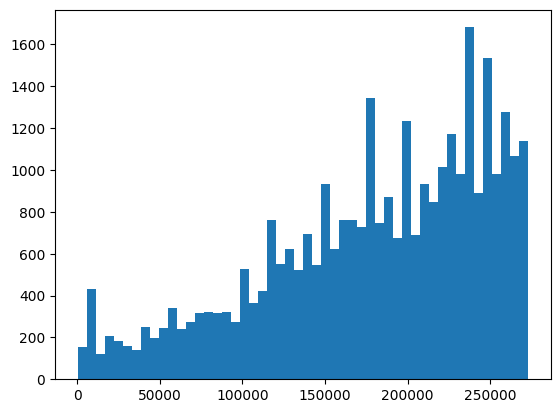

In [21]:
low_price = data[data['lastSalePrice'] < 273000]

plt.hist(low_price['lastSalePrice'], bins=50)
plt.show()

In [22]:
very_low = data[data['lastSalePrice'] < 50000]
very_low.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1856 entries, 17 to 145570
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   formattedAddress  1856 non-null   object 
 1   city              1856 non-null   object 
 2   zipCode           1856 non-null   int64  
 3   county            1856 non-null   object 
 4   latitude          1856 non-null   float64
 5   longitude         1856 non-null   float64
 6   propertyType      1856 non-null   object 
 7   bedrooms          1856 non-null   float64
 8   bathrooms         1856 non-null   float64
 9   squareFootage     1856 non-null   float64
 10  lotSize           1856 non-null   float64
 11  yearBuilt         1856 non-null   float64
 12  lastSalePrice     1856 non-null   float64
 13  cooling           1856 non-null   int64  
 14  heating           1856 non-null   int64  
 15  fireplace         1856 non-null   int64  
 16  floorCount        1856 non-null   float64
 1

In [23]:
very_low.describe()

,zipCode,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,heating,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate
count,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000
mean,33694.045259,28.387355,-82.098982,2.923491,1.919181,1484.111530,14678.240841,1998.526940,24004.441810,0.501078,0.531789,0.080819,1.030711,0.402478,1.077047,0.046875,26.473060,0.043364
std,847.335199,1.300961,1.253845,0.801997,0.555481,539.084268,39684.385319,27.690459,14349.527576,0.500134,0.499123,0.272630,0.178719,0.490530,0.316639,0.211428,27.690459,0.002142
min,32008.000000,25.092931,-87.433430,1.000000,0.500000,200.000000,0.000000,1891.000000,310.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.037200
25%,32909.000000,26.994397,-82.270068,2.000000,2.000000,1136.000000,6970.000000,1978.000000,10000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.042100
50%,33955.500000,28.865827,-82.009606,3.000000,2.000000,1456.000000,10019.000000,2004.000000,22600.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,21.000000,0.043100
75%,34470.000000,29.145343,-81.630390,3.000000,2.000000,1810.000000,12632.000000,2024.000000,38000.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,47.000000,0.045400
max,34997.000000,30.971297,-80.053292,6.000000,6.000000,6009.000000,871200.000000,2025.000000,49900.000000,1.000000,1.000000,1.000000,3.000000,1.000000,6.000000,1.000000,134.000000,0.046300


In [24]:
very_low[very_low['bedrooms'] == 6]

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate
1463,"1115 Joseph St, Jacksonville, FL 32206",Jacksonville,32206,Duval,30.346933,-81.640630,Single Family,6.0,2.0,1474.0,...,48900.0,1,1,0,2.0,0,1.0,0,111.0,0.0421
91479,"1045 E 24th St, Jacksonville, FL 32206",Jacksonville,32206,Duval,30.359815,-81.641962,Single Family,6.0,3.5,1723.0,...,45000.0,1,1,1,1.0,0,1.0,0,97.0,0.0431
124552,"2223 Carver Ave, Fort Myers, FL 33916",Fort Myers,33916,Lee,26.638425,-81.846618,Single Family,6.0,5.0,1832.0,...,47000.0,0,0,0,1.0,0,1.0,0,1.0,0.0387
124559,"2219 Carver Ave, Fort Myers, FL 33916",Fort Myers,33916,Lee,26.638720,-81.846619,Single Family,6.0,5.0,2000.0,...,47000.0,0,0,0,1.0,0,1.0,0,1.0,0.0387


These are either inaccurate or very old without renovations. May need to filter for both year built and price range.

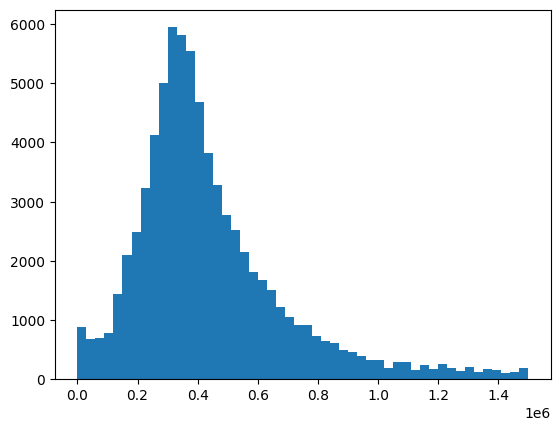

In [25]:
newer = data[data['yearBuilt'] >= 1980]

plt.hist(newer['lastSalePrice'], bins=50, range=(0, 1_500_000))
plt.show()

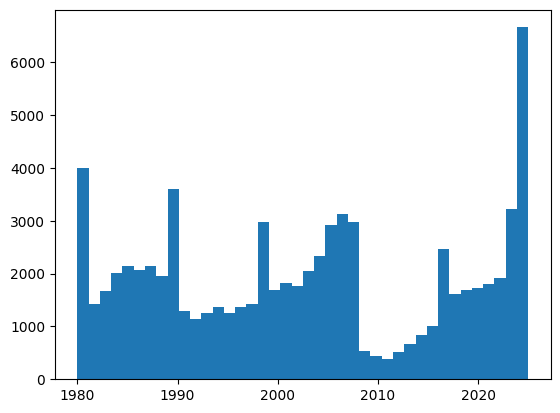

In [26]:
plt.hist(newer['yearBuilt'], bins=40)
plt.show()

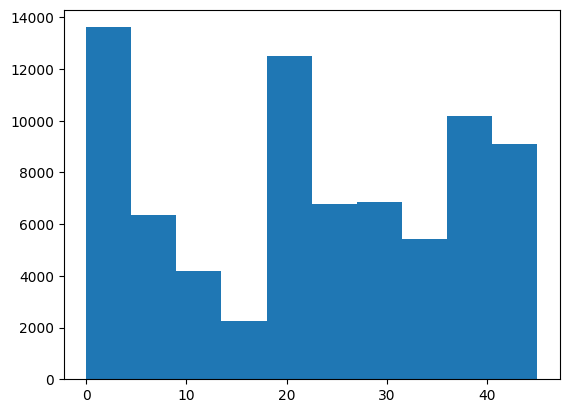

In [27]:
plt.hist(newer['years_old'])
plt.show()

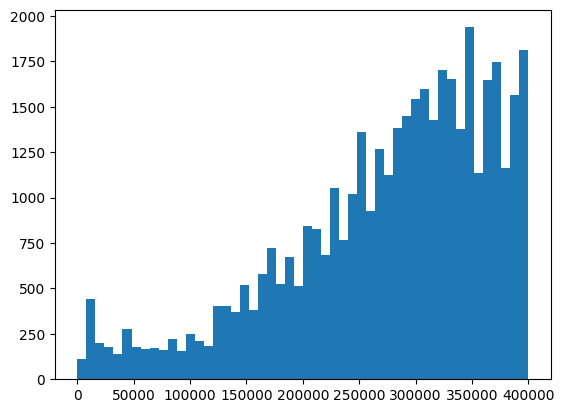

In [28]:
# Zooming in on that lower dip

plt.hist(newer['lastSalePrice'], bins=50, range=(0, 400000))
plt.show()

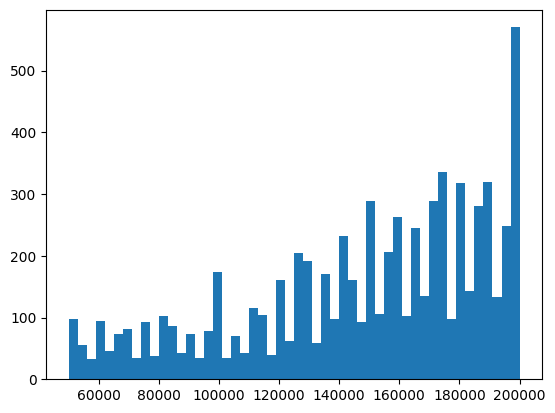

In [29]:
plt.hist(newer['lastSalePrice'], bins=50, range=(50000, 200000))
plt.show()

In [30]:
# filtering by price

filtered = newer[(newer['lastSalePrice'] > 100_000) & ((newer['lastSalePrice'] < 1_000_000))]

In [31]:
filtered.shape

(68224, 22)

In [32]:
filtered['county'].value_counts().head(15)

county
Palm Beach      4739
Lee             4693
Hillsborough    4460
Orange          3682
Polk            3562
Broward         3462
Miami-Dade      3454
Duval           3049
Pasco           2875
Osceola         2271
Marion          2217
Volusia         2183
Brevard         2043
Manatee         2041
Sarasota        1985
Name: count, dtype: int64

In [33]:
county_counts = filtered['county'].value_counts()
big_counties= county_counts[county_counts >= 2216].index

filtered = filtered[filtered['county'].isin(big_counties)]

filtered.shape

(38464, 22)

In [34]:
filtered = filtered.copy()
filtered['zipCode'] = filtered['zipCode'].astype(str)

In [35]:
num_var = [
    'latitude',
    'longitude',
    'bedrooms',
    'bathrooms',
    'squareFootage',
    'lotSize',
    # 'yearBuilt',
    # 'subdivision',
    # 'zoning',
    # 'lastSaleDate',
    'floorCount',
    'lastSalePrice',
    'years_old',
    'pool',
    'cooling',
    'heating',
    'fireplace',
    'garage',
    'garageSpaces',
    't_rate',
]

cat_var = [
    'city',
    'zipCode',
    'county',
    'propertyType',
]

In [36]:
# Getting dummies for cat_var

cat_data = pd.get_dummies(filtered[cat_var])

# Recreating the dataframe with the numerical and dummy columns 

model_data = pd.concat([filtered[num_var], cat_data], axis=1)

In [37]:
# Features and target, splitting data

y = model_data['lastSalePrice']
X = model_data.drop(['lastSalePrice'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [38]:
# For app

model_columns = X.columns.tolist()
dump(model_columns, open('/workspaces/mds8-final-project-bmh/src/model_columns.sav', 'wb'))

model_cities = filtered['city'].unique().tolist()
model_cities.sort()
dump(model_cities, open('/workspaces/mds8-final-project-bmh/src/model_cities.sav', 'wb'))

In [39]:
filtered['garageSpaces'].unique()

array([ 1.,  2.,  4.,  3.,  5.,  6.,  8., 11.,  9.])

In [40]:
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38464 entries, 4 to 145612
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   formattedAddress  38464 non-null  object 
 1   city              38464 non-null  object 
 2   zipCode           38464 non-null  object 
 3   county            38464 non-null  object 
 4   latitude          38464 non-null  float64
 5   longitude         38464 non-null  float64
 6   propertyType      38464 non-null  object 
 7   bedrooms          38464 non-null  float64
 8   bathrooms         38464 non-null  float64
 9   squareFootage     38464 non-null  float64
 10  lotSize           38464 non-null  float64
 11  yearBuilt         38464 non-null  float64
 12  lastSalePrice     38464 non-null  float64
 13  cooling           38464 non-null  int64  
 14  heating           38464 non-null  int64  
 15  fireplace         38464 non-null  int64  
 16  floorCount        38464 non-null  float64
 1

In [41]:
zip_county_dict = dict(zip(filtered['zipCode'], filtered['county']))
dump(zip_county_dict, open('/workspaces/mds8-final-project-bmh/src/zip_county_dict.sav', 'wb'))

In [42]:
city_zip_dict = filtered.groupby('city')['zipCode'].unique().apply(list).to_dict()
dump(city_zip_dict, open('/workspaces/mds8-final-project-bmh/src/city_zip_dict.sav', 'wb'))

In [43]:
x_test_idx = X_test.index

In [44]:
X_train.shape

(30771, 650)

In [45]:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 0.8}

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 8,
 'n_estimators': 200,
 'reg_alpha': 0,
 'reg_lambda': 1.5,
 'subsample': 0.8}

In [46]:
# XGBoost Regressor

xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_test)

print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

RMSE: 83588.90497043726
Coefficient of determination: 0.7947923946308426


In [65]:
xgb_model = XGBRegressor(
    objective='reg:squarederror', 
    random_state=42,
    learning_rate=0.1, 
    max_depth=8, 
    n_estimators=200, 
    reg_alpha=0, 
    reg_lambda=1.5, 
    subsample=0.8)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

RMSE: 81410.33727685653
Coefficient of determination: 0.8053496053357986


In [48]:
dump(xgb_model, open('../models/matt_xgbr_opt.sav', 'wb'))

In [49]:
param_grid = {
    'max_depth': [8, 10, 12], # check the depth 
    'learning_rate': np.logspace(0.01, 0.1, 3), 
    'subsample': [0.5, 0.8, 1.0],
    'reg_alpha': np.logspace(0, 0.1, 3),
    'reg_lambda': np.linspace(1, 2, 3)
}

# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring='neg_root_mean_squared_error',
#     cv=3,
#     verbose=2,
# )

# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)

In [50]:
model_data.shape

(38464, 651)

In [62]:
importance = xgb_model.feature_importances_
feature_names = xgb_model.feature_names_in_

feat_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

feat_importance_df.head(25)


,feature,importance
641,county_Orange,0.027992
640,county_Miami-Dade,0.026117
645,county_Polk,0.018432
4,squareFootage,0.016776
183,city_Tampa,0.013876
639,county_Marion,0.013065
89,city_Jacksonville Beach,0.012617
224,zipCode_32218,0.011744
32,city_Boynton Beach,0.011490
137,city_Ocala,0.010617


In [52]:
# Rebuild test data before dummies using original DataFrame
original_test_data = filtered.loc[x_test_idx].copy()

original_test_data.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate
49062,"1019 Green Pine Blvd, Apt A, West Palm Beach, ...",West Palm Beach,33409,Palm Beach,26.730286,-80.107813,Condo,2.0,2.0,1370.0,...,240000.0,0,0,0,1.0,0,1.0,0,41.0,0.0454
84964,"230 Nw 195th Ave, Pembroke Pines, FL 33029",Pembroke Pines,33029,Broward,26.009127,-80.408281,Single Family,3.0,2.0,2365.0,...,650000.0,1,0,0,1.0,1,1.0,0,32.0,0.0431
90234,"5667 Arvine Cir, Fort Myers, FL 33919",Fort Myers,33919,Lee,26.570513,-81.885919,Condo,3.0,2.0,1768.0,...,550000.0,1,1,0,1.0,1,1.0,0,42.0,0.0431
85409,"6165 Carrier Dr, # 3208, Orlando, FL 32819",Orlando,32819,Orange,28.456985,-81.468790,Condo,1.0,1.0,408.0,...,150000.0,0,0,0,1.0,0,1.0,0,39.0,0.0431
40335,"12791 Sw 228th St, Miami, FL 33170",Miami,33170,Miami-Dade,25.555328,-80.397853,Single Family,4.0,3.0,2409.0,...,875000.0,0,0,0,1.0,0,1.0,0,8.0,0.0454


In [53]:
# Looking at results

X_test_df = pd.DataFrame(original_test_data).reset_index(drop=True)

y_test_df = pd.DataFrame(y_test).reset_index(drop=True)
y_test_df.columns = ['actual_price']

y_pred_df = pd.DataFrame(y_pred).reset_index(drop=True)
y_pred_df.columns = ['predicted_price']

test_data = pd.concat([X_test_df, y_test_df, y_pred_df], axis=1)

test_data.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,heating,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate,actual_price,predicted_price
0,"1019 Green Pine Blvd, Apt A, West Palm Beach, ...",West Palm Beach,33409,Palm Beach,26.730286,-80.107813,Condo,2.0,2.0,1370.0,...,0,0,1.0,0,1.0,0,41.0,0.0454,240000.0,255550.046875
1,"230 Nw 195th Ave, Pembroke Pines, FL 33029",Pembroke Pines,33029,Broward,26.009127,-80.408281,Single Family,3.0,2.0,2365.0,...,0,0,1.0,1,1.0,0,32.0,0.0431,650000.0,795172.687500
2,"5667 Arvine Cir, Fort Myers, FL 33919",Fort Myers,33919,Lee,26.570513,-81.885919,Condo,3.0,2.0,1768.0,...,1,0,1.0,1,1.0,0,42.0,0.0431,550000.0,372807.593750
3,"6165 Carrier Dr, # 3208, Orlando, FL 32819",Orlando,32819,Orange,28.456985,-81.468790,Condo,1.0,1.0,408.0,...,0,0,1.0,0,1.0,0,39.0,0.0431,150000.0,178117.875000
4,"12791 Sw 228th St, Miami, FL 33170",Miami,33170,Miami-Dade,25.555328,-80.397853,Single Family,4.0,3.0,2409.0,...,0,0,1.0,0,1.0,0,8.0,0.0454,875000.0,727828.687500


In [54]:
test_data['pct_error'] = (test_data['predicted_price'] - test_data['actual_price']) / test_data['actual_price']

test_data.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate,actual_price,predicted_price,pct_error
0,"1019 Green Pine Blvd, Apt A, West Palm Beach, ...",West Palm Beach,33409,Palm Beach,26.730286,-80.107813,Condo,2.0,2.0,1370.0,...,0,1.0,0,1.0,0,41.0,0.0454,240000.0,255550.046875,0.064792
1,"230 Nw 195th Ave, Pembroke Pines, FL 33029",Pembroke Pines,33029,Broward,26.009127,-80.408281,Single Family,3.0,2.0,2365.0,...,0,1.0,1,1.0,0,32.0,0.0431,650000.0,795172.687500,0.223343
2,"5667 Arvine Cir, Fort Myers, FL 33919",Fort Myers,33919,Lee,26.570513,-81.885919,Condo,3.0,2.0,1768.0,...,0,1.0,1,1.0,0,42.0,0.0431,550000.0,372807.593750,-0.322168
3,"6165 Carrier Dr, # 3208, Orlando, FL 32819",Orlando,32819,Orange,28.456985,-81.468790,Condo,1.0,1.0,408.0,...,0,1.0,0,1.0,0,39.0,0.0431,150000.0,178117.875000,0.187452
4,"12791 Sw 228th St, Miami, FL 33170",Miami,33170,Miami-Dade,25.555328,-80.397853,Single Family,4.0,3.0,2409.0,...,0,1.0,0,1.0,0,8.0,0.0454,875000.0,727828.687500,-0.168196


In [55]:
test_data['pct_error'].describe()

count    7693.000000
mean        0.043182
std         0.263823
min        -0.687798
25%        -0.080755
50%         0.003941
75%         0.103700
max         6.758545
Name: pct_error, dtype: float64

In [56]:
high_error = test_data[test_data['pct_error'] > .1]

In [57]:
high_error.groupby('propertyType')['pct_error'].mean()

propertyType
Condo            0.303906
Manufactured     0.427953
Single Family    0.320605
Townhouse        0.321577
Name: pct_error, dtype: float64

In [58]:
test_data[test_data['pct_error'] > 6]

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate,actual_price,predicted_price,pct_error
3729,"1050 Ne 2nd Ter, Boca Raton, FL 33432",Boca Raton,33432,Palm Beach,26.359968,-80.081231,Single Family,5.0,5.5,4321.0,...,0,2.0,1,1.0,1,6.0,0.0454,128571.0,916441.6875,6.127904
5121,"1100 State Rd, 557, Lake Alfred, FL 33850",Lake Alfred,33850,Polk,28.110942,-81.732336,Single Family,3.0,4.0,3732.0,...,1,2.0,1,1.0,0,32.0,0.0431,102260.0,793388.8125,6.758545


In [59]:
high_error.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate,actual_price,predicted_price,pct_error
1,"230 Nw 195th Ave, Pembroke Pines, FL 33029",Pembroke Pines,33029,Broward,26.009127,-80.408281,Single Family,3.0,2.0,2365.0,...,0,1.0,1,1.0,0,32.0,0.0431,650000.0,795172.68750,0.223343
3,"6165 Carrier Dr, # 3208, Orlando, FL 32819",Orlando,32819,Orange,28.456985,-81.468790,Condo,1.0,1.0,408.0,...,0,1.0,0,1.0,0,39.0,0.0431,150000.0,178117.87500,0.187452
8,"624 Heraldo Ct, Kissimmee, FL 34758",Kissimmee,34758,Osceola,28.154725,-81.460259,Single Family,4.0,2.0,2769.0,...,0,1.0,1,1.0,0,21.0,0.0425,375000.0,425171.62500,0.133791
15,"3016 Parkway Blvd, Apt 106, Kissimmee, FL 34747",Kissimmee,34747,Osceola,28.338567,-81.535808,Condo,2.0,2.0,937.0,...,0,1.0,0,1.0,0,35.0,0.0425,140000.0,217279.46875,0.551996
16,"2503 Se 8th Ave, Cape Coral, FL 33904",Cape Coral,33904,Lee,26.606135,-81.958126,Single Family,4.0,2.5,2409.0,...,0,1.0,0,1.0,0,1.0,0.0421,520000.0,585883.87500,0.126700


In [60]:
high_error['lotSize'].describe()

count      1968.000000
mean       7953.846037
std       19689.260111
min           0.000000
25%           0.000000
50%        5750.000000
75%        9594.000000
max      401125.000000
Name: lotSize, dtype: float64